In [1]:
import random
import gurobipy as gp
from gurobipy import GRB
import copy
import numpy as np

def generate_data(n: int) -> list:
    """ A simple function to generate random data. 
        We ensured that there is 1/3 chance that the edges are not connected with eachother

    Args:
        n (int): The input variables that describes the amount of nodes

    Returns:
        list: Returns a matrix of weights of the edges 
    """
    # Initializing an empty adjacency matrix with zeros
    W = [[0] * n for _ in range(n)]

    # Generate random edge weights (assuming non-negative weights)
    for i in range(n):
        for j in range(i+1, n):
            t = random.randint(0,2)
            if t == 0:
                weight = 0
            else:
                weight = random.randint(1,10)
            # weight = random.uniform(0, 2)  # Adjust the range as needed
            # Ensure that edges are undirected by setting W[i][j] = W[j][i] = weight
            W[i][j] = W[j][i] = weight
    return W

In [2]:
def BP(W: list, n: int) -> list:
    """ The binary programming function for max cut problems

    Args:
        W (list): A matrix of weights of the edges 
        n (int): The input variables that describes the amount of nodes

    Returns:
        list: The optimal y variables for the max cut problem
    """
    # Create a new model
    m = gp.Model("mip1")
    # Create variable

    x = {}
    x = m.addVars(range(n),vtype = "B", name="x")
    y = m.addVars(range(n),range(n),vtype = "B", name="y")

    m.setObjective(sum(W[i][j]*y[i,j] for i in range(n) for j in range(n)), GRB.MAXIMIZE)
    m.addConstrs(y[i,j]<=(x[i]+x[j]) for i in range(n) for j in range(n))
    m.addConstrs(y[i,j]+x[i]+x[j]<=2 for i in range(n) for j in range(n))
    m.optimize()
    y_result=[]

    for v in x.values():
        if v.X == 0 or v.X==-0:
            y_result.append(0)
        else:
            y_result.append(1)
    return y_result

In [3]:
def count_weight(W:list, A:list, B:list) -> int:
    """ This function counts the sum of weights based on the two sets

    Args:
        W (list): Matrix of the edge weights
        A (list): All nodes that belong to set A
        B (list): All nodes that belong to set B

    Returns:
        int: the sum of weights that gets cut from set A to set B
    """
    total_weight = 0
    for i in A:
        for j in B:
            total_weight += W[i][j]
    return total_weight

In [4]:
def weight_change(W: list, A: list, B: list, current_weight: int) -> list:
    """ This function will calculate the changes 
        if you swap a node from set 1 to set 2 or vice versa

    Args:
        W (list): Matrix of the edge weights
        A (list): All nodes that belong to set A
        B (list): All nodes that belong to set B
        current_weight (int): The current weight before you make any changes

    Returns:
        list: List of all the weight changes if you swap one node to the other
    """
    weight_change_list = []
    for i in range(len(W)):
        temp_A = A.copy()
        temp_B = B.copy()
        if i in A:

            temp_B.append(i)
            temp_A.remove(i)
        else:

            temp_A.append(i)
            temp_B.remove(i)
        new_weight = count_weight(W, temp_A, temp_B)
        result = new_weight - current_weight
        weight_change_list.append(result)
    return weight_change_list

In [5]:
def random_set(n: int) -> [list, list]:
    """ Generates a random set A and a random set B.

    Args:
        n (int): number of nodes

    Returns:
        [list, list]: The output set A and set B
    """
    A = []
    B = []

    for i in range(n):
        r = random.randint(0,1)
        if r == 0:
            A.append(i)
        else:
            B.append(i)
    return A, B

In [6]:
def GH(W: list, A: list, B: list, n: int) -> [int, list, list]:
    """ This function performs the greedy heuristic. It takes a random partition A and B.
        It will then calculate the original weight. It will then chronologically loop over the nodes.
        It will temp put the chronological node into the other set and check if the sum of weight is higher.
        If it is higher then this node remains in that set and otherwise it returns to its old set.
        Finally it will output the sum of weights from this heuristic and also the corresponding set A and set B.

    Args:
        W (list): A matrix of the edges weights
        A (list): Set A random partitioned of the max-cut problem
        B (list): Set B random partitioned of the max-cut problem
        n (int): Number of nodes

    Returns:
        [int, list, list]: The sum of weights from this heuristic and also the corresponding set A and set B.
    """
    total_weight = count_weight(W, A, B)
    for i in range(n):
        temp_A = A.copy()
        temp_B = B.copy()
        if i in A:
            temp_B.append(i)
            temp_A.remove(i)
        else:
            temp_A.append(i)
            temp_B.remove(i)
        new_weight = count_weight(W, temp_A, temp_B)
        if new_weight >= total_weight:
            A = temp_A
            B = temp_B
            total_weight = new_weight
    A = sorted(A)
    B = sorted(B)
    total_weight = count_weight(W, A, B)
    return total_weight, A, B

In [7]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import datetime
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
tf.random.set_seed(42)
log_dir = "logs/fit/" + "single_layer"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Generate random integer input values
num_samples = 1000
min_value = -50
max_value = 50

input_values = np.random.randint(min_value, max_value + 1, size=num_samples)

# Create labels: 1 for negative integers, 0 for non-negative integers
labels = (input_values < 0).astype(int)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(input_values, labels, test_size=0.2, random_state=42)

model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(1,)),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')



Epoch 1/50
25/25 [==============================] - 2s 27ms/step - loss: 0.4499 - accuracy: 0.7725 - val_loss: 0.1994 - val_accuracy: 1.0000
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 0.1383 - accuracy: 0.9962 - val_loss: 0.1163 - val_accuracy: 1.0000
Epoch 3/50
25/25 [==============================] - 0s 7ms/step - loss: 0.1004 - accuracy: 1.0000 - val_loss: 0.0910 - val_accuracy: 1.0000
Epoch 4/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0844 - accuracy: 1.0000 - val_loss: 0.0768 - val_accuracy: 1.0000
Epoch 5/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0740 - accuracy: 1.0000 - val_loss: 0.0669 - val_accuracy: 1.0000
Epoch 6/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0664 - accuracy: 1.0000 - val_loss: 0.0590 - val_accuracy: 1.0000
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0603 - accuracy: 1.0000 - val_loss: 0.0532 - val_accuracy: 1.0000
Epoch 8/50
25/25 [=

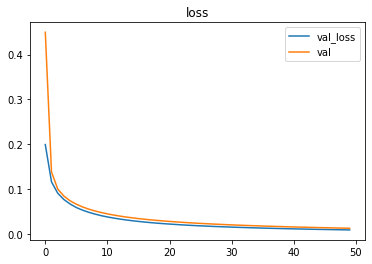

In [8]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='val')
plt.title('loss')
plt.legend()

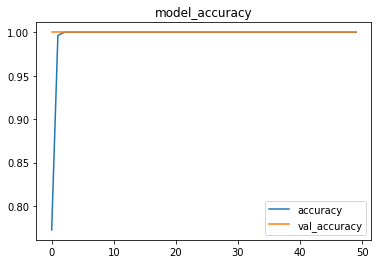

In [9]:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('model_accuracy')
plt.legend()

In [10]:
pred_f = model.predict(x_test)
pred = np.round(pred_f).tolist()
pred = [[round(x) for x in sublist] for sublist in pred]
print(accuracy_score(pred,y_test)*100)

7/7 [==============================] - 0s 3ms/step
100.0


In [11]:
n = 25
k = 100

NN_weights = []
GH_weights = []

W = generate_data(n)

for z in range(k):

    A_raw, B_raw = random_set(n)
    
    GH_weight, A_GH, B_GH = GH(W,A_raw,B_raw,n)

    A_NN = copy.deepcopy(A_raw)
    B_NN = copy.deepcopy(B_raw)

    for i in range(n):
        pred_round = []
        current_weight = count_weight(W, A_NN, B_NN)
        NN_input = weight_change(W, A_NN, B_NN, current_weight)

        #Check if there is any weights above 0. If there isn't then we have reached the maximum and thus we can stop the loop
        if max(NN_input)>=0:
            change_node = model.predict(np.array(NN_input))
            pred = np.round(change_node).tolist()
            pred = [[round(x) for x in sublist] for sublist in pred]
            
            for i in range(len(pred)):
                pred_round.append(pred[i][0])

            # Check if there are zero values in the list and select it
            zero_indices = [index for index, value in enumerate(pred_round) if value == 0]
            index = random.choice(zero_indices)

            #Swap the index to the other set
            if index in A_NN:
                B_NN.append(index)
                A_NN.remove(index)
            else:
                A_NN.append(index)
                B_NN.remove(index)
        
        #We stop the loop and go to the next round
        else:
            break
    #calculate the weights of the NN and add it to the list. Simultaneously add GH results to list so that they can be compared.
    NN_weight = count_weight(W, A_NN, B_NN)
    NN_weights.append(NN_weight)
    GH_weights.append(GH_weight)



1/1 [==============================] - 0s 47ms/step


In [12]:
NN_wins = 0
GH_wins = 0

for i in range(len(NN_weights)):
    if NN_weights[i]>=GH_weights[i]:
        NN_wins+=1
    else:
        GH_wins+=1

print(f"number of NN wins is {(NN_wins/len(NN_weights))*100}%")
print(f"number of GH wins is {(GH_wins/len(NN_weights)*100)}%")

number of NN wins is 94.0%
number of GH wins is 6.0%


## Comparison BP and MLGH
Lets test the speed of the Binary Programming. The BP will take approximately 5-6 min for 25 nodes whereas our MLGH takes approximately 4 to 5 min with 25 nodes. This is including various other operations as can be seen in the cell(s) above. Keep in mind that running speed may depend on the operating system.

In [13]:
bp_list = []

for i in range(k):
    W = generate_data(100)
    bp = BP(W,n)
    bp_list.append(bp)

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)



CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1250 rows, 650 columns and 3700 nonzeros
Model fingerprint: 0x92ec24a8
Variable types: 0 continuous, 650 integer (650 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 836 rows and 418 columns
Presolve time: 0.01s
Presolved: 414 rows, 232 columns, 1242 nonzeros
Variable types: 0 continuous, 232 integer (232 binary)
Found heuristic solution: objective 1138.0000000

Root relaxation: objective 2.312000e+03, 28 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2312.00000    0